# Single-cell ATACseq Tutorial

## Background
This tutorial demonstrates the principle behind the analysis of spatially resolvable single-cell ATACseq data. The transposase-accessible chromatin using sequencing (ATAC-Seq) assay has been widely adopted since its development by Jason Buenrostro and colleagues in the Greenleaf lab in 2013, and it’s now one of the most popular approaches to investigate chromatin openness and its dynamics.

ATAC-Seq is used to identify regions of the genome that have open chromatin states that are generally associated with sites undergoing active transcription. Transcription factor binding sites and positions of nucleosomes can also be identified from the analysis of ATAC-Seq data, potentially allowing important genetic pathways in the samples to be elucidated.

<img src="https://ars.els-cdn.com/content/image/1-s2.0-S2001037020303019-ga1_lrg.jpg" alt="Drawing" style="width:1000px;"/>

## Overview and Purpose
The dataset we use here comes from Lareau et al., Nat Biotech 2019, one of the highest throughput single-cell ATAC-seq experiments to date. They assay 136K resting and stimulated bone marrow-derived cells and study the different cell types and lineages that emerge. The paper analyzes resting & stimulated cells separately (and we also find that these two populations split into largely distinct clusters), so here we only focus on the 60K resting cells from this experiment.

The cell metadata from this experiment includes annotated putative cell types based on chromVAR, Louvain clustering, and downstream cluster analysis. We compare our de novo identified clusters to these annotated clusters from the paper (and find good agreement).

The peak-cell matrix along with peak and cell metadata files are publicly available on GEO, GSE123580.

<img src="https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41467-021-21583-9/MediaObjects/41467_2021_21583_Fig1_HTML.png?as=webp" alt="Drawing" style="width:1000px;"/>

## Standard single-cell ATACseq workflow
The steps below encompass the standard pre-processing workflow. These represent the selection and filtration of cells based on QC metrics, data normalization and scaling, and the detection of highly variable features.

This tutorial will cover the following tasks.
- QC and selecting cells
- Normalization
- Identifying highly variable features
- Scaling the data
- Linear Dimensional reduction 
- Determining Dimensionality
- Clustering
- Assigning cell type identity to clusters
- Detecting spatially variable features
- Interactive visualization
- Integration with single-cell RNA-seq data

In [3]:
from IPython.display import HTML

# Youtube
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/uuxpyhGNDsk?controls=0" frameborder="0" allowfullscreen></iframe>')

In [4]:
!pip install jupyterquiz
import jupyterquiz
from jupyterquiz import display_quiz
display_quiz("/home/jupyter/tutorials/duplicateQuiz.json")

<IPython.core.display.Javascript object>

In [6]:
!pwd

/home/jupyter/tutorials


In [7]:
!pip install ipywidgets

<div class="alert-info" style="font-size:200%">
STEP 1: Setting up environment
</div>

<div class="alert-info" style="font-size:200%">
STEP 1a: Run the following commands in TERMINAL
</div>

In [ ]:
#To access terminal
#follow this path File > New > Terminal
#Then do Step 1b to 1f in Terminal
#Do step 1g in Jupyter notebook

In [ ]:
# 1b Create conda environment for rapids, then activate it 
conda create -n rapidsai
conda activate rapidsai

In [ ]:
# 1c install rapids
conda install -c rapidsai -c nvidia -c conda-forge python=3.7 cudatoolkit=11.2 rapids=21.12 llvmlite gcsfs openssl dask-sql

In [ ]:
# 1d install scanpy and wget
pip install scanpy wget

In [ ]:
# 1e add rapidsai environ
python -m ipykernel install --user --name=rapidsai
jupyter kernelspec list

In [ ]:
# 1f download required files
wget https://raw.githubusercontent.com/NVIDIA-Genomics-Research/rapids-single-cell-examples/master/notebooks/utils.py
wget https://raw.githubusercontent.com/NVIDIA-Genomics-Research/rapids-single-cell-examples/master/notebooks/rapids_scanpy_funcs.py
wget https://raw.githubusercontent.com/NVIDIA-Genomics-Research/rapids-single-cell-examples/master/notebooks/dsci_bmmc_60k_gpu.ipynb

In [ ]:
# 1g open notebook and change kernel in jupyter notebook to use rapidsai envs
# jupyter menu: goto > kernel > change kernel > rapidsai

In [ ]:
# create conda envs
#run these two lines on terminal
conda create -n rapidsai
conda activate rapidsai

In [ ]:
#run this line on terminal
conda install -y --prefix /usr/local -c rapidsai -c nvidia -c conda-forge python=3.7 cudatoolkit=11.2 rapids=21.12 llvmlite gcsfs openssl dask-sql

In [ ]:
#run this line on terminal
python -m ipykernel install --user --name=rapidsai

In [ ]:
#run this line on terminal
jupyter kernelspec list

In [ ]:
#in jupyter notebook, do the following.
Click on jupyter menu: goto > kernel > change kernel > rapidsai

The following files
- processed peak-cell count matrix for this dataset (.h5ad)
- set of nonzero peak names (.npy)
- cell metadata (.csv)
are stored inside the data folder

In [5]:
!python -m ipykernel install --user --name scATACtraining
numthreads=!lscpu | grep '^CPU(s)'| awk '{print $2-1}'
numthreadsint = int(numthreads[0])
!conda config --prepend channels bioconda
#!python -m pip install --user --upgrade cutadapt
!conda install -y -c anaconda cuml cudf cupy
!pip install jupyterquiz
from jupyterquiz import display_quiz
from IPython.display import IFrame
from IPython.display import display
import pandas as pd

Installed kernelspec scATACtraining in /home/jupyter/.local/share/jupyter/kernels/scatactraining
Solving environment: done

# All requested packages already installed.

Retrieving notices: ...working... done


# Import Sample Files
Now lets create some folders to stay organized and copy over our prepared raw files. We're going to create a directory called "Tutorial1" which we'll use for this module. We'll then create subfolders for our InputFiles and for the files that we'll be creating during this module.

In [6]:
#These commands create our directory structure.
!cd $HOMEDIR
!mkdir -p Tutorial2
!mkdir -p Tutorial2/InputFiles
!echo $PWD

#These commands help identify the google cloud storage bucket where the example files are held.
project_id = "nosi-unmc-seq"
original_bucket = "gs://unmc_singlecell_atac_data_examples"
#This command copies our example files to the Tutorial1/Inputfiles folder that we created above.
! gsutil cp $original_bucket/Tutorial1/dsci_resting_cell_metadata.csv Tutorial2/InputFiles
! gsutil cp $original_bucket/Tutorial1/dsci_resting_nonzeropeaks.h5ad Tutorial2/InputFiles
! gsutil cp $original_bucket/Tutorial1/dsci_resting_peaknames_nonzero.npy Tutorial2/InputFiles

/home/jupyter/tutorials
Copying gs://unmc_singlecell_atac_data_examples/Tutorial1/dsci_resting_cell_metadata.csv...
/ [1 files][  3.5 MiB/  3.5 MiB]                                                
Operation completed over 1 objects/3.5 MiB.                                      
Copying gs://unmc_singlecell_atac_data_examples/Tutorial1/dsci_resting_nonzeropeaks.h5ad...
==> NOTE: You are downloading one or more large file(s), which would            
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

\ [1 files][404.4 MiB/404.4 MiB]                                                
Operation completed over 1 objects/404.4 MiB.                                    
Copying gs://unmc_singlecell_atac_data_examples/Tutorial1/dsci_resting_peaknames_nonzero.npy...
/ [1 files][ 13.7 MiB/ 13.7 MiB]                                                
Operation completed over 1 objec

# Let's make sure that the files copied correctly. 
# You should see 3 files after running the following command:

In [7]:
!ls Tutorial2/InputFiles

dsci_resting_cell_metadata.csv	dsci_resting_peaknames_nonzero.npy
dsci_resting_nonzeropeaks.h5ad


In [8]:
%pip install numpy
%pip install scanpy
%pip install anndata
%pip install matplotlib
%pip install utils
%pip install rapids

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached utils-1.0.1-py2.py3-none-any.whl (21 kB)
Note: you may need to restart the kernel to use updated packages.
  Using cached rapids-0.0.1-py3-none-any.whl (10 kB)
  Using cached pyramid-2.0-py3-none-any.whl (246 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.2/254.2 kB 6.8 MB/s eta 0:00:00a 0:00:01
  Using cached venusian-3.0.0-py3-none-any.whl (13 kB)
  Using cached plaster-1.1-py2.py3-none-any.whl (11 kB)
  Using cached hupper-1.10.3-py2.py3-none-any.whl (26 kB)
  Using cached WebOb-1.8.7-py2.py3-none-any.whl (114 kB)
  Using cached zope.deprecation-4.4.0-py2.py3-none-any.whl (10 kB)
  Using cached plaster_pastedeploy-1.0.1-py2.py3-none-any.whl (7.8 kB)
  Using cached translationstring-1.4-py2.py3-none-any.

In [9]:
!pip install wget

In [10]:
pip install scanpy wget

Note: you may need to restart the kernel to use updated packages.


In [11]:
import numpy as np
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
from collections import OrderedDict

import time
import os, wget

import cudf
import cupy as cp

from cuml.decomposition import PCA
from cuml.manifold import TSNE

import rapids_scanpy_funcs
import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')

In [12]:
!rm utils.py
!rm rapids_scanpy_funcs.py
!wget https://raw.githubusercontent.com/NVIDIA-Genomics-Research/rapids-single-cell-examples/master/notebooks/utils.py
!wget https://raw.githubusercontent.com/NVIDIA-Genomics-Research/rapids-single-cell-examples/master/notebooks/rapids_scanpy_funcs.py

--2022-11-17 17:50:34--  https://raw.githubusercontent.com/NVIDIA-Genomics-Research/rapids-single-cell-examples/master/notebooks/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4257 (4.2K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   4.16K  --.-KB/s    in 0s      

2022-11-17 17:50:34 (49.1 MB/s) - ‘utils.py’ saved [4257/4257]

--2022-11-17 17:50:34--  https://raw.githubusercontent.com/NVIDIA-Genomics-Research/rapids-single-cell-examples/master/notebooks/rapids_scanpy_funcs.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request

In [13]:
import rmm

rmm.reinitialize(
    managed_memory=True, # Allows oversubscription
    devices=0, # GPU device IDs to register. By default registers only GPU 0.
)

cp.cuda.set_allocator(rmm.rmm_cupy_allocator)

In [72]:
# filtering peaks
n_top_peaks = 5000 # Number of peaks to retain

# PCA
n_components = 50 # Number of principal components to compute

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# KNN
n_neighbors = 10 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.4 
umap_spread = 1.0

# Differential peaks
n_diff_peaks = 50 # Number of differential peaks to compute for each cluster

# Marker genes
# Gene coordinates are in GRCh37, from grch37.ensembl.org
markers = ['MS4A1', 'LEF1', 'NKG7', 'TREM1', 'GATA1', 'PAX5']
marker_coords = OrderedDict()
marker_coords['MS4A1'] = ['chr11', 60223225, 60238233, 'fwd']
marker_coords['LEF1'] = ['chr4', 108968701, 109090112, 'rev']
marker_coords['NKG7'] = ['chr19', 51874860, 51875969, 'rev']
marker_coords['TREM1'] = ['chr6', 41235664, 41254457, 'rev']
marker_coords['GATA1'] = ['chrX', 48644962, 48652716, 'fwd']
marker_coords['PAX5'] = ['chr9', 36833272, 37034103, 'rev']

In [73]:
start_time = time.time()

In [74]:
%%time
input_file = "../data/dsci_resting_nonzeropeaks.h5ad"

if not os.path.exists(input_file):
    print('Downloading import file...')
    os.makedirs('../data', exist_ok=True)
    wget.download('https://rapids-single-cell-examples.s3.us-east-2.amazonaws.com/dsci_resting_nonzeropeaks.h5ad',
                  input_file)

adata = anndata.read_h5ad(input_file)
adata_raw = adata.copy()
print(adata.X.shape)

(60495, 143691)
CPU times: user 473 ms, sys: 502 ms, total: 975 ms
Wall time: 971 ms


In [75]:
preprocessing_start = time.time()

In [77]:
%%time

lognormalized = utils.logtf_idf(adata.X, pseudocount=10**3)
adata.X = lognormalized

CPU times: user 2.03 s, sys: 1.39 s, total: 3.42 s
Wall time: 3.63 s


In [78]:
%%time
adata = utils.filter_peaks(adata, n_top_peaks)
print(adata.X.shape)

(60495, 5000)
CPU times: user 933 ms, sys: 110 ms, total: 1.04 s
Wall time: 1.41 s


In [79]:
print("Preprocessing time: %.2fsec" % (time.time() - preprocessing_start))

Preprocessing time: 163.79sec


In [81]:
%%time
adata = anndata.AnnData(X=adata.X.todense(),
                        obs=adata.obs,
                        var=adata.var)
adata.obsm["X_pca"] = PCA(n_components=n_components).fit_transform(adata.X)
adata.obsm["X_pca"].shape

CPU times: user 3.23 s, sys: 1min 33s, total: 1min 36s
Wall time: 1min 39s


(60495, 50)

In [82]:
%%time
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs, method='rapids')

CPU times: user 12.6 s, sys: 415 ms, total: 13 s
Wall time: 23.9 s


In [83]:
%%time
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread, method='rapids')

CPU times: user 795 ms, sys: 383 ms, total: 1.18 s
Wall time: 5.5 s


In [84]:
%%time
sc.tl.louvain(adata, flavor='rapids')

CPU times: user 152 ms, sys: 17.1 ms, total: 169 ms
Wall time: 994 ms


In [85]:
%%time
adata.obs['leiden'] = rapids_scanpy_funcs.leiden(adata)

CPU times: user 115 ms, sys: 20.6 ms, total: 136 ms
Wall time: 201 ms


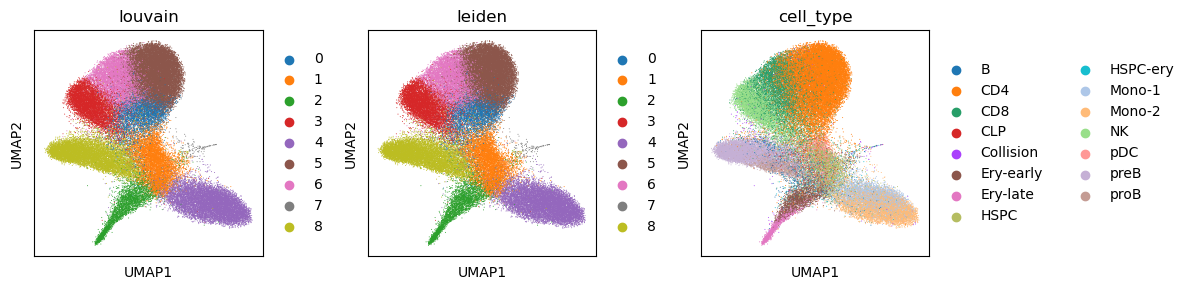

CPU times: user 1.81 s, sys: 348 ms, total: 2.16 s
Wall time: 2.19 s


In [86]:
%%time

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 3), dpi=100)

sc.pl.umap(adata, color=['louvain'], ax=axs[0], show=False)
sc.pl.umap(adata, color=['leiden'], ax=axs[1], show=False)
sc.pl.umap(adata, color=['cell_type'], ax=axs[2], show=False)

plt.tight_layout()
plt.show()

In [87]:
%%time
adata.obsm['X_tsne'] = TSNE().fit_transform(adata.obsm["X_pca"][:, :tsne_n_pcs])

[W] [19:21:05.865505] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
CPU times: user 2.09 s, sys: 1.08 s, total: 3.17 s
Wall time: 4.91 s


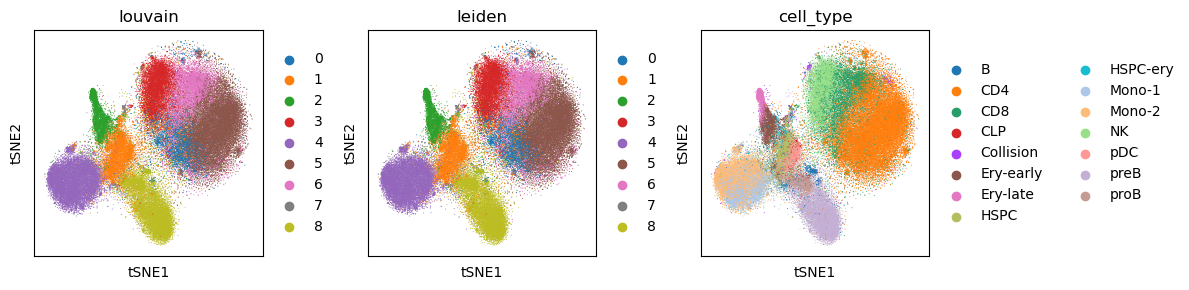

CPU times: user 1.82 s, sys: 236 ms, total: 2.05 s
Wall time: 1.58 s


In [88]:
%%time

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 3), dpi=100)

sc.pl.tsne(adata, color=['louvain'], ax=axs[0], show=False)
sc.pl.tsne(adata, color=['leiden'], ax=axs[1], show=False)
sc.pl.tsne(adata, color=['cell_type'], ax=axs[2], show=False)

plt.tight_layout()
plt.show()

In [89]:
%%time
# find which peaks overlap with each marker gene (+ 5kb upstream)
peaks_per_gene = {gene : [] for gene in markers}

for (i, peak) in enumerate(adata_raw.var_names):
    chrom, coords = peak.strip().split(':')
    start, end = [int(c) for c in coords.split('-')]
    for gene in markers:
        if utils.overlap(marker_coords[gene], [chrom, start, end], 5000, 0):
            peaks_per_gene[gene].append((i, peak))

for gene in peaks_per_gene:
    print(f"{gene} has {len(peaks_per_gene[gene])} nearby peaks")

MS4A1 has 2 nearby peaks
LEF1 has 30 nearby peaks
NKG7 has 4 nearby peaks
TREM1 has 5 nearby peaks
GATA1 has 6 nearby peaks
PAX5 has 30 nearby peaks
CPU times: user 504 ms, sys: 0 ns, total: 504 ms
Wall time: 502 ms


In [90]:
%%time
# Calculate per-cell gene activity scores for each marker gene
cell_gene_scores = np.zeros((adata.X.shape[0], len(marker_coords.keys())))
for (i, gene) in enumerate(peaks_per_gene.keys()):
    indices = [x[0] for x in peaks_per_gene[gene]]
    peak_scores = adata_raw.X[:, indices].toarray()
    cell_gene_scores[:, i] = np.sum(peak_scores, axis=1) + 1

# Store per-cell gene activity scores with adata
for (i, gene) in enumerate(markers):
    adata.obs[gene] = np.log2(cell_gene_scores[:, i].tolist())
    adata.obs.loc[np.isneginf(adata.obs[gene]), gene] = 0

CPU times: user 731 ms, sys: 24 ms, total: 755 ms
Wall time: 780 ms


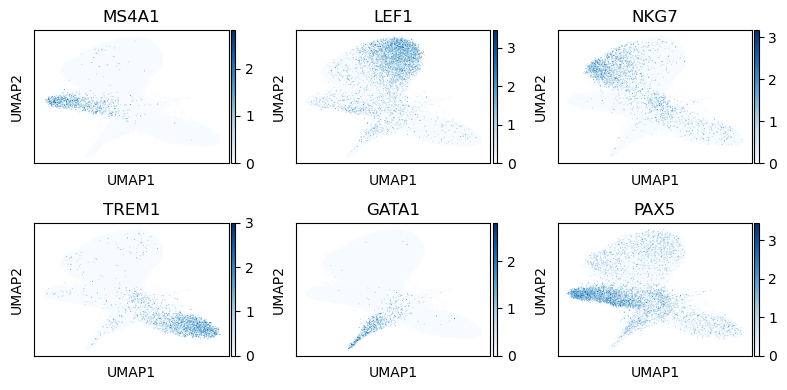

CPU times: user 1.68 s, sys: 137 ms, total: 1.82 s
Wall time: 1.55 s


In [92]:
%%time

fig, axs = plt.subplots(nrows=2, ncols=3, figsize = (8, 4), dpi=100)
axs = axs.flatten()
for (i, gene) in enumerate(markers):
    sc.pl.umap(adata, color_map="Blues", color=gene, ax = axs[i], show=False)
plt.tight_layout()
plt.show()

In [93]:
%%time
cluster_labels = cudf.Series.from_categorical(adata.obs["louvain"].cat)
var_names = cudf.Series(adata.var_names)
dense_gpu_array = cp.sparse.csr_matrix(cp.array(adata.X))

scores, names, reference = rapids_scanpy_funcs.rank_genes_groups(
    dense_gpu_array,
    cluster_labels, 
    var_names, 
    penalty='none',
    n_genes=n_diff_peaks, groups='all', reference='rest')

[W] [19:22:53.551574] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
CPU times: user 11.7 s, sys: 4.2 s, total: 15.9 s
Wall time: 15.8 s


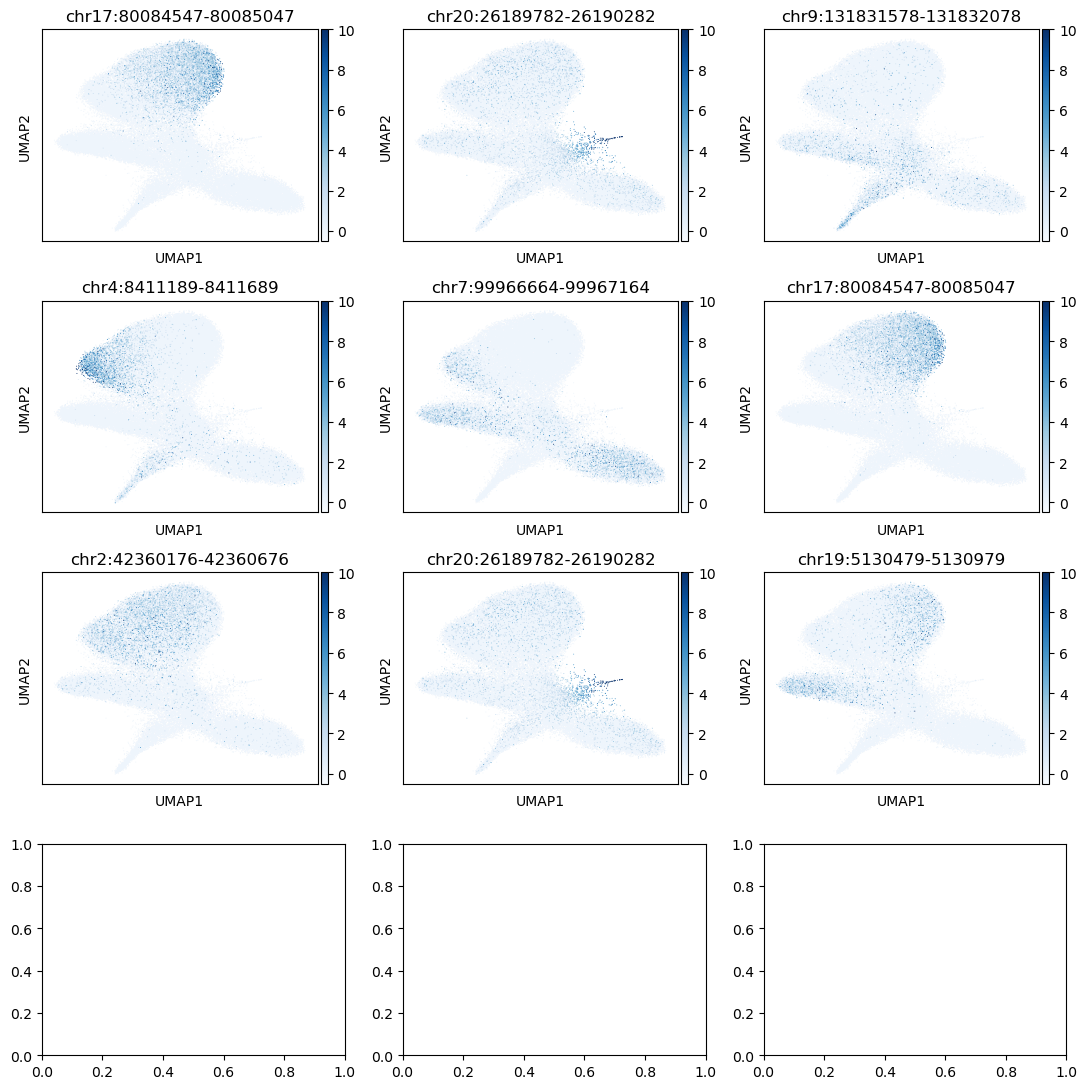

CPU times: user 2.91 s, sys: 164 ms, total: 3.07 s
Wall time: 2.8 s


In [95]:
%%time
fig, axs = plt.subplots(len(names[0])//3 + 1, 3, figsize=(11,11), dpi=100)
axs = axs.flatten()

for (i, peak) in enumerate(names[0]):
    sc.pl.umap(adata, color=peak, 
           ax=axs[i], show=False,
           vmax=10, vmin=-0.5,
           cmap='Blues'
          )
plt.tight_layout()
plt.show()

In [96]:
print("Full time: %.2fsec" % (time.time() - start_time))

Full time: 754.25sec


In [38]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [40]:
conda install -c rapidsai rmm

Solving environment: done

# All requested packages already installed.

Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [42]:
conda update -n base -c defaults conda

Solving environment: done

# All requested packages already installed.

Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [11]:
!pip install jupytercards
import jupytercards
from jupytercards import display_flashcards
display_flashcards("/home/jupyter/tutorials/my_cards-2.json")

<IPython.core.display.Javascript object>

In [46]:
display_quiz("/home/jupyter/tutorials/Quiz-2.json")

<IPython.core.display.Javascript object>

In [12]:
import jupytercards
from jupytercards import display_flashcards
display_flashcards("/home/jupyter/tutorials/my_cards-2.json")

<IPython.core.display.Javascript object>

In [13]:
import jupytercards
from jupytercards import display_flashcards
display_flashcards("/home/jupyter/tutorials/my_cards.json")

<IPython.core.display.Javascript object>

In [14]:
!pip install matplotlib

In [30]:
import os
import time
import numpy as np
import anndata
import utils

In [31]:
import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')

In [32]:
import rmm

In [33]:
import scanpy as sc

In [34]:
!pip install python-utils
from utils import *

In [35]:
!pip install cp

In [36]:
!pip install cp-tool

In [37]:
import cp

In [38]:
conda install -c anaconda cudatoolkit

Solving environment: done

# All requested packages already installed.

Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [2]:
conda install -c nvidia cuda-toolkit

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - cuda-toolkit


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cuda-cccl-11.8.89          |                0         1.2 MB  nvidia
    cuda-command-line-tools-11.8.0|                0           1 KB  nvidia
    cuda-compiler-11.8.0       |                0           1 KB  nvidia
    cuda-cudart-11.8.89        |                0         197 KB  nvidia
    cuda-cudart-dev-11.8.89    |                0         1.1 MB  nvidia
    cuda-cuobjdump-11.8.86     |                0         229 KB  nvidia
    cuda-cupti-11.8.87         |                0        25.3 MB  nvidia
    cuda-cuxxfilt-11.8.86      |                0         291 KB  nvidia
    cuda-documentation-11.8.86 |                0          89 KB  nvidia
    cuda-driver-dev-11.8.89    |                0          16 KB  n

In [2]:
import cuda

ModuleNotFoundError: No module named 'cuda'

In [10]:
rmm.reinitialize(
    managed_memory=True, # Allows oversubscription
    devices=0, # GPU device IDs to register. By default registers only GPU 0.
)

cp.cuda.set_allocator(rmm.rmm_cupy_allocator)

AttributeError: module 'cp' has no attribute 'cuda'

In [33]:
!pip install cudf

In [34]:
import cudf

UnSupportedCUDAError: Please update your NVIDIA GPU Driver to support CUDA Runtime.
Detected CUDA Runtime version : 11080
Latest version of CUDA supported by current NVIDIA GPU Driver : 11000

In [55]:
conda install -c conda-forge tsne

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - tsne


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2022.9.24  |       ha878542_0         150 KB  conda-forge
    certifi-2022.9.24          |     pyhd8ed1ab_0         155 KB  conda-forge
    conda-22.9.0               |   py37h89c1867_1         960 KB  conda-forge
    tsne-0.3.1                 |   py37hc71f0f9_3          85 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         1.3 MB

The following NEW packages will be INSTALLED:

  tsne               conda-forge/linux-64::tsne-0.3.1-py37hc71f0f9_3 None

The following packages will be UPDATED:

  ca-certificates    anaconda::ca-certificates-2022.07.19-~ --> conda-forge::ca-certificates-2022.9.24-ha878542_0 None
  certifi 

In [53]:
from cp import cp.set_allocator
print(cp.set_allocator)

SyntaxError: invalid syntax (<ipython-input-53-97d50c385922>, line 1)

In [15]:
rmm.reinitialize(
    managed_memory=True, # Allows oversubscription
    devices=0, # GPU device IDs to register. By default registers only GPU 0.
)

var = cp.set_allocator(rmm.rmm_cupy_allocator())

AttributeError: module 'cp' has no attribute 'set_allocator'

In [6]:
conda install -c rapidsai cudf

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - cudf


The following packages will be UPDATED:

  ca-certificates    conda-forge::ca-certificates-2022.9.2~ --> pkgs/main::ca-certificates-2022.10.11-h06a4308_0 None

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi            conda-forge/noarch::certifi-2022.9.24~ --> pkgs/main/linux-64::certifi-2022.9.24-py37h06a4308_0 None
  conda              conda-forge::conda-22.9.0-py37h89c186~ --> pkgs/main::conda-22.9.0-py37h06a4308_0 None


Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [2]:
import cudf

UnSupportedCUDAError: Please update your NVIDIA GPU Driver to support CUDA Runtime.
Detected CUDA Runtime version : 11080
Latest version of CUDA supported by current NVIDIA GPU Driver : 11000

<div class="alert-info" style="font-size:200%">
STEP 2: Setting up parameters
</div>

In [25]:
import collections
 
try:
    from collections import OrderedDict
except ImportError:
    OrderedDict = dict

In [26]:
import anndata

In [27]:
import utils

In [28]:
# filtering peaks
n_top_peaks = 25000 # Number of peaks to retain

# PCA
n_components = 50 # Number of principal components to compute

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# KNN
n_neighbors = 10 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.4 
umap_spread = 1.0

# Differential peaks
n_diff_peaks = 50 # Number of differential peaks to compute for each cluster

# Marker genes
# Gene coordinates are in GRCh37, from grch37.ensembl.org
markers = ['MS4A1', 'LEF1', 'NKG7', 'TREM1', 'GATA1', 'PAX5']
marker_coords = OrderedDict()
marker_coords['MS4A1'] = ['chr11', 60223225, 60238233, 'fwd']
marker_coords['LEF1'] = ['chr4', 108968701, 109090112, 'rev']
marker_coords['NKG7'] = ['chr19', 51874860, 51875969, 'rev']
marker_coords['TREM1'] = ['chr6', 41235664, 41254457, 'rev']
marker_coords['GATA1'] = ['chrX', 48644962, 48652716, 'fwd']
marker_coords['PAX5'] = ['chr9', 36833272, 37034103, 'rev']

In [39]:
start_time = time.time()

# Input data

In the cell below, we provide the path to the sparse .h5ad file containing the peak x cell count matrix to analyze.

In [40]:
%%time
input_file = "/home/jupyter/tutorials/Tutorial2/InputFiles/dsci_resting_nonzeropeaks.h5ad"

if not os.path.exists(input_file):
    print('Downloading import file...')
    os.makedirs('data', exist_ok=True)

adata = anndata.read_h5ad(input_file)
adata_raw = adata.copy()
print(adata.X.shape)

(60495, 143691)
CPU times: user 356 ms, sys: 379 ms, total: 735 ms
Wall time: 3.81 s


<div class="alert-info" style="font-size:200%">
STEP 3: Preprocessing
</div>

In [41]:
preprocessing_start = time.time()

In [4]:
!pwd

/home/jupyter/tutorials


# tf-idf normalization
We use log1p(pseudocount / tf)*idf, motivated by our results on various scATAC datasets.

In [43]:
%%time
lognormalized = utils.logtf_idf(adata.X, pseudocount=10**3)
adata.X = lognormalized

AttributeError: module 'utils' has no attribute 'logtf_idf'

In [44]:
import utils

In [45]:
%%time

lognormalized = utils.logtf_idf(adata.X, pseudocount=10**3)
adata.X = lognormalized

AttributeError: module 'utils' has no attribute 'logtf_idf'

In [46]:
%%time

lognormalized = utils.logtf_idf(adata.X, pseudocount=10**3)
adata.X = lognormalized

AttributeError: module 'utils' has no attribute 'logtf_idf'

# Frequency-based peak selection

We want to choose peaks that have highest discriminative power between cells. A good proxy for discriminative power is variance; since peak data (especially on a sparse dataset like this) is essentially binary, the highest variance peaks are the ones with closest to 50\% representation across cells (p=1/2 maximizes Bernoulli variance). The most frequent peak in this dataset only has 33\% representation, so in practice we just end up taking the top N most frequent peaks, where N is a parameter we set above (default 25000).

In [47]:
%%time
adata = utils.filter_peaks(adata, n_top_peaks)
print(adata.X.shape)

AttributeError: module 'utils' has no attribute 'filter_peaks'

In [48]:
print("Preprocessing time: %.2fsec" % (time.time() - preprocessing_start))

Preprocessing time: 65.99sec


<div class="alert-info" style="font-size:200%">
STEP 4: Clustering & Visualization
</div>

## PCA

In [49]:
%%time
adata = anndata.AnnData(X=adata.X.todense(),
                        obs=adata.obs,
                        var=adata.var)
adata.obsm["X_pca"] = PCA(n_components=n_components).fit_transform(adata.X)
adata.obsm["X_pca"].shape

MemoryError: Unable to allocate 32.4 GiB for an array with shape (60495, 143691) and data type float32

# UMAP visualization

In [50]:
%%time
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs, method='rapids')

         Falling back to preprocessing with `sc.pp.pca` and default params.


UnSupportedCUDAError: Please update your NVIDIA GPU Driver to support CUDA Runtime.
Detected CUDA Runtime version : 11080
Latest version of CUDA supported by current NVIDIA GPU Driver : 11000

In [51]:
%%time
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread, method='rapids')

ValueError: Did not find .uns["neighbors"]. Run `sc.pp.neighbors` first.

## Graph clustering
Below, we show how to use the RAPIDS Louvain clustering or Leiden clustering functions to cluster the data.

In [61]:
%%time
sc.tl.louvain(adata, flavor='rapids')

KeyError: 'No "neighbors" in .uns'

In [5]:
%%time
adata.obs['leiden'] = rapids_scanpy_funcs.leiden(adata)

NameError: name 'rapids_scanpy_funcs' is not defined

Below, we plot the UMAP visualization of the cells colored by the Louvain clusters. Next, we color the cells using the cell type annotations reported in the source paper. We see that the clusters we discovered match closely with the reported cell types.

In [58]:
%%time

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 3), dpi=100)

sc.pl.umap(adata, color=['louvain'], ax=axs[0], show=False)
sc.pl.umap(adata, color=['leiden'], ax=axs[1], show=False)
sc.pl.umap(adata, color=['cell_type'], ax=axs[2], show=False)

plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

## tSNE visualization

In [47]:
%%time
adata.obsm['X_tsne'] = TSNE().fit_transform(adata.obsm["X_pca"][:, :tsne_n_pcs])

NameError: name 'TSNE' is not defined

In [48]:
%%time

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 3), dpi=100)

sc.pl.tsne(adata, color=['louvain'], ax=axs[0], show=False)
sc.pl.tsne(adata, color=['leiden'], ax=axs[1], show=False)
sc.pl.tsne(adata, color=['cell_type'], ax=axs[2], show=False)

plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

## Marker genes

We now compute a gene activity score representing the activity of each marker gene in each cell. We use the adata_raw object to compute this score. This allows us to consider all peaks, not just the subset we used for clustering and UMAP.

In [49]:
%%time
# find which peaks overlap with each marker gene (+ 5kb upstream)
peaks_per_gene = {gene : [] for gene in markers}

for (i, peak) in enumerate(adata_raw.var_names):
    chrom, coords = peak.strip().split(':')
    start, end = [int(c) for c in coords.split('-')]
    for gene in markers:
        if utils.overlap(marker_coords[gene], [chrom, start, end], 5000, 0):
            peaks_per_gene[gene].append((i, peak))

for gene in peaks_per_gene:
    print(f"{gene} has {len(peaks_per_gene[gene])} nearby peaks")

AttributeError: module 'utils' has no attribute 'overlap'

In [ ]:
%%time
# Calculate per-cell gene activity scores for each marker gene
cell_gene_scores = np.zeros((adata.X.shape[0], len(marker_coords.keys())))
for (i, gene) in enumerate(peaks_per_gene.keys()):
    indices = [x[0] for x in peaks_per_gene[gene]]
    peak_scores = adata_raw.X[:, indices].toarray()
    cell_gene_scores[:, i] = np.sum(peak_scores, axis=1) + 1

# Store per-cell gene activity scores with adata
for (i, gene) in enumerate(markers):
    adata.obs[gene] = np.log2(cell_gene_scores[:, i].tolist())
    adata.obs.loc[np.isneginf(adata.obs[gene]), gene] = 0

In [ ]:
!pip install plt

We now visualize the UMAP plot colored by activity of marker genes. We observe that the activation of cell-type specific marker genes correlates well with the cell types identified by Louvain clustering.

In [ ]:
%%time

fig, axs = plt.subplots(nrows=2, ncols=3, figsize = (8, 4), dpi=100)
axs = axs.flatten()
for (i, gene) in enumerate(markers):
    sc.pl.umap(adata, color_map="Blues", color=gene, ax = axs[i], show=False)
plt.tight_layout()
plt.show()

## Find Differential peaks
We perform an accelerated logistic regression-based differential peak computation using RAPIDS. This function may not give the exact same results as the equivalent Scanpy CPU function.

<div class="alert-info" style="font-size:200%">
STEP 5: Finding differential peaks
</div>

In [ ]:
%%time
cluster_labels = cudf.Series.from_categorical(adata.obs["louvain"].cat)
var_names = cudf.Series(adata.var_names)
dense_gpu_array = cp.sparse.csr_matrix(cp.array(adata.X))

scores, names, reference = rapids_scanpy_funcs.rank_genes_groups(
    dense_gpu_array,
    cluster_labels, 
    var_names, 
    penalty='none',
    n_genes=n_diff_peaks, groups='all', reference='rest')

In [ ]:
%%time
fig, axs = plt.subplots(len(names[0])//3 + 1, 3, figsize=(11,11), dpi=100)
axs = axs.flatten()

for (i, peak) in enumerate(names[0]):
    sc.pl.umap(adata, color=peak, 
           ax=axs[i], show=False,
           vmax=10, vmin=-0.5,
           cmap='Blues'
          )
plt.tight_layout()
plt.show()